In [ ]:
import os
import time
import pickle
import logging
import argparse

import numpy as np
import pandas as pd
import functools

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing import Pool as ProcessPool 

import trackml.dataset

In [27]:
def remove_some_noise(hits, cells, truth, keep=1.0):
    if keep == 1.0:
        return hits, cells, truth
    unique_ids = truth.particle_id.unique()
    track_ids_to_keep = unique_ids[np.where(unique_ids != 0)]

    where_to_keep = truth['particle_id'].isin(track_ids_to_keep)
    
    noise_hit_idx = hits[~where_to_keep].hit_id.values
    if keep <= 0.0:
        noise_hit_idx = []
    else:
        noise_hit_idx = np.random.permutation(noise_hit_idx)[:int(keep * noise_hit_idx.shape[0])]
        
    hits_reduced  = pd.concat([hits[where_to_keep], hits[hits['hit_id'].isin(noise_hit_idx)]])
    truth_reduced = pd.concat([truth[where_to_keep],  truth[truth['hit_id'].isin(noise_hit_idx)]])

    hit_ids_to_keep = truth_reduced.hit_id.values
    cells_reduced = cells[cells['hit_id'].isin(hit_ids_to_keep)]
    return hits_reduced, cells_reduced, truth_reduced

In [28]:
dir_path = "/global/cfs/cdirs/m3443/data/trackml-kaggle/train_all"
event_path = os.path.join(dir_path, "event000001000")

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


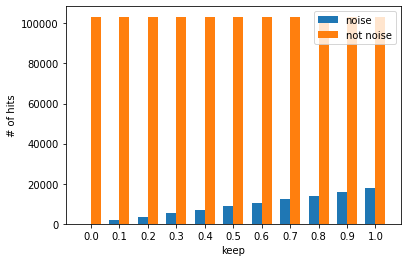

In [40]:
hits, cells, particles, truth = trackml.dataset.load_event(event_path)
pt = np.sqrt(particles.px**2 + particles.py**2 + particles.pz**2)
particles = particles.assign(pt=pt)
keeps = np.arange(0.0, 1.1, 0.1)
print(keeps)

noise_hits = []
not_noise_hits = []

for i in keeps:
    _, _, reduced_truth = remove_some_noise(hits, cells, truth, i)
    n_noise = sum(reduced_truth['particle_id'] == 0)
    noise_hits.append(n_noise)
    not_noise_hits.append(len(reduced_truth) - n_noise)

x = np.arange(len(keeps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noise_hits, width, label='noise')
rects2 = ax.bar(x + width/2, not_noise_hits, width, label='not noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of hits')
ax.set_xlabel('keep')
ax.set_xticks(x)
labels = ['%.1f' % (i,) for i in keeps]
ax.set_xticklabels(labels)
ax.legend()